# Introduction
This notebook walks through the fiducial registration process for just a single US/MPM image pair, and using the functions transferred to the multicscale-imaging package.

In [2]:
# Import basic moduless
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import matplotlib.pyplot as plt
import tiffile as tif
import pickle
import os

In [3]:
# These modules all come from the multiscale-imaging package: https://github.com/uw-loci/multiscale
import multiscale.LINK_system.coordinate as coord
import multiscale.itk.transform as tran
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.microscopy.ome as ome
import multiscale.LINK_system.image_classes as link

In [4]:
fiducial_dir = Path(r'F:\Research\LINK\Mouse images\2019-10-21 - Mouse 210v2\Fiducial')

mpm_tile_path = Path(fiducial_dir, r'L38 Fiducial MPM settings.ome.tif')
mpm_path = Path(fiducial_dir, r'L38 Fiducial MPM Down4x.tif')

us_height = 13115

us_path = Path(fiducial_dir, r'L38 fiducial Z' + str(us_height) + ' 8bit 50dB.tif')
us_pl_path = Path(fiducial_dir, 'L38 fiducial Z' + str(us_height) + '.pos')
us_param_path = Path(fiducial_dir, r'L38 fiducial Z' + str(us_height) + '_Run-1_Settings.mat')
dynamic_range = None

Open the images

In [5]:
mpm_image = coord.open_microscopy(mpm_path, mpm_tile_path, downsample_factor=4)

In [6]:
us_spacing = [24.0004, 24.0004, 24.0004]
us_image = coord.open_us(us_path, us_pl_path, us_param_path, us_spacing, us_height, dynamic_range)

Acquire similar points between images

<IPython.core.display.Javascript object>


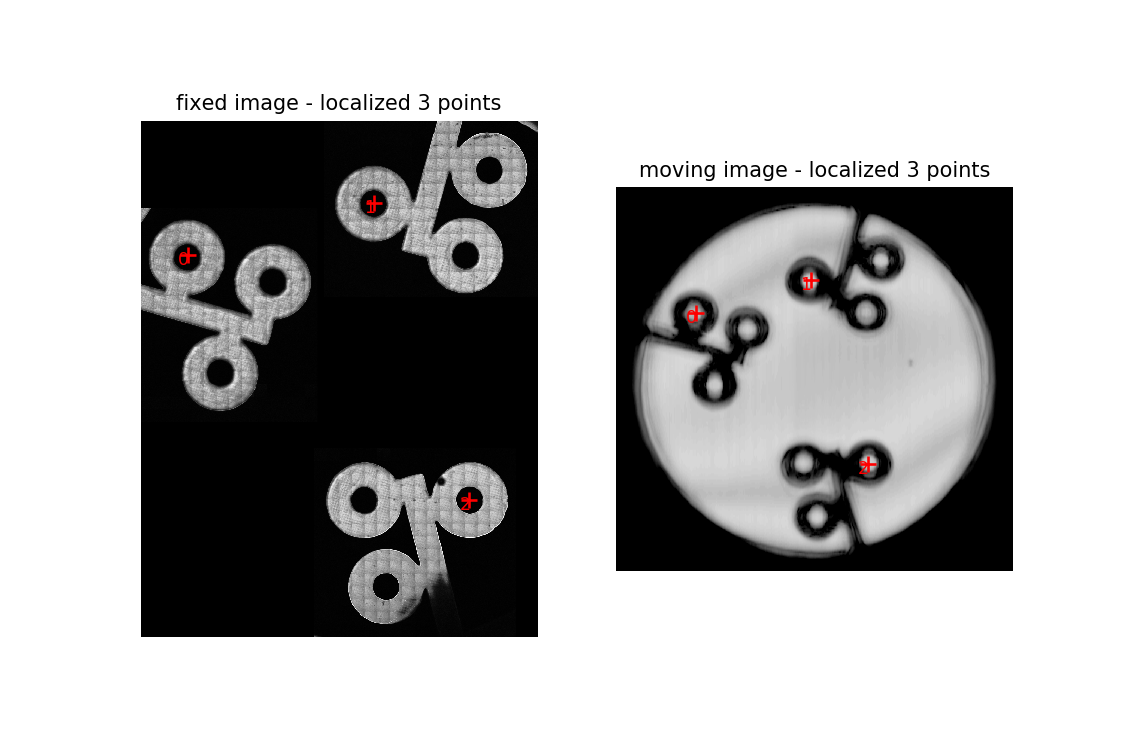

In [7]:
points = iplt.RegistrationPointDataAcquisition(mpm_image, us_image)

In [8]:
fixed_points, moving_points = points.get_points_flat()

Register the images

In [9]:
landmark_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points, moving_points)
landmark_params = landmark_transform.GetParameters()
initial_transform = sitk.TranslationTransform(3, [landmark_params[3], landmark_params[4], landmark_params[5]])

final_transform, metric, stop = reg.register(mpm_image, us_image, initial_transform=initial_transform)
final_params = final_transform.GetParameters()

In [10]:
centroid, labeled_img = coord.calculate_centroid(us_image[:, :, 59:168], radius=True, output_label_img=True)

Threshold used: 40.0


Box(children=(IntSlider(value=54, description='image slice:', max=108),))

<IPython.core.display.Javascript object>


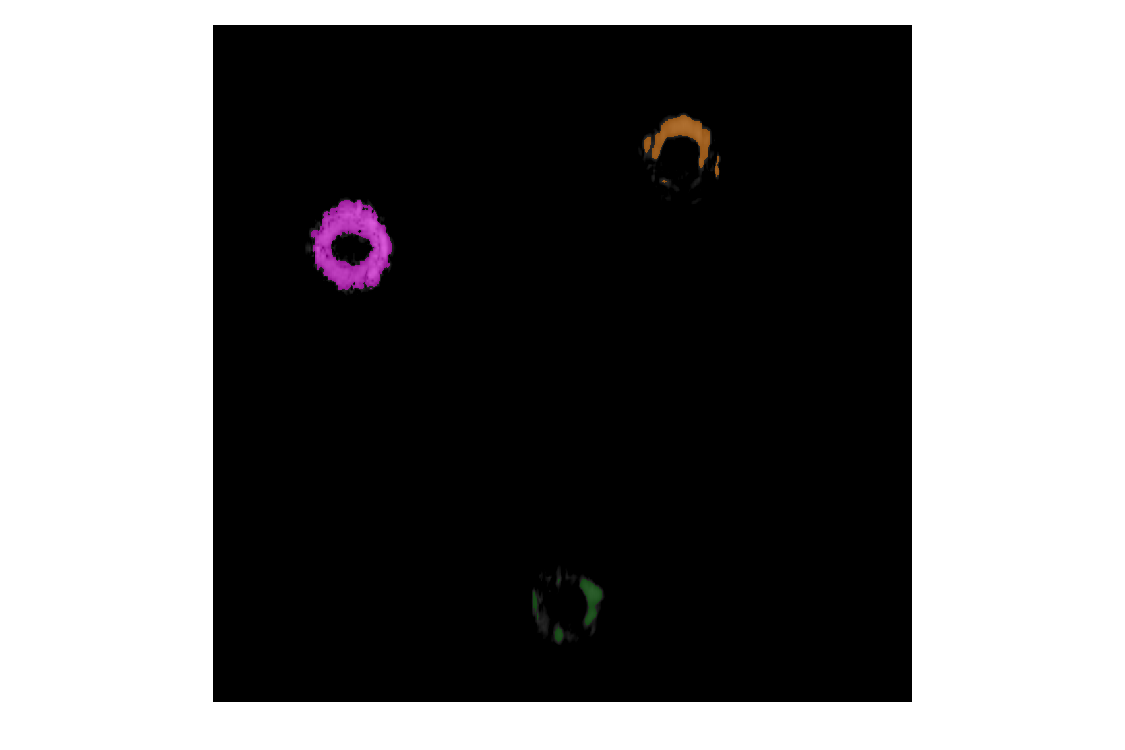

In [11]:
iplt.MultiImageDisplay([sitk.LabelOverlay(us_image[:, :, 59:168], labeled_img)])

In [12]:
fiducial_bottom = np.mean(centroid)

z_translation = fiducial_bottom - (mpm_image.GetOrigin()[2]-25*2)

In [13]:
coordinate_transform = np.array(final_params)
coordinate_transform[2] = z_translation
print('Final coordinate transform: {}'.format(coordinate_transform))

Final coordinate transform: [-3104.35189186  3773.31892593 20999.71167947]


In [14]:
# Save the results
coordinate_path = Path(fiducial_dir, 'L38 Transform.txt')
with open(coordinate_path, 'wb') as fp:
    pickle.dump(coordinate_transform, fp)

In [ ]:
registered_dir = Path(fiducial_dir, 'Registered')

In [ ]:
mpm_reg_path = Path(registered_dir, 'MPM Reg to US.tif')

In [ ]:
mpm_reg = tran.apply_transform_params(us_image, mpm_image, 
                                     -1*coordinate_transform,
                                     sitk.VersorRigid3DTransform())

In [ ]:
sitk.WriteImage(mpm_reg, str(mpm_reg_path))

In [ ]:
# Index 0 is no shift, index 1 is 1mm, 2 is 2mm, 3 is 3mm.
height_transforms = [coordinate_transform.copy() for idx in range(4)]
for idx in range(4):
    height_transforms[idx][5] = coordinate_transform[5] - 1000*idx

In [ ]:
mpm_reg = [tran.apply_transform_params(us_image, mpm_image, -1*height_transforms[idx], sitk.VersorRigid3DTransform()) for idx in range(4)]
# for idx in range(4):
#     reg_path = Path(registered_dir, 'MPM Height Reg {}mm.tif'.format(idx))
#     sitk.WriteImage(mpm_reg[idx], str(reg_path))

In [ ]:
# Add together the MPM images at all 4 locations to show them in the US volume.
mpm_all_reg = mpm_reg[0] + mpm_reg[1] + mpm_reg[2] + mpm_reg[3]
reg_path = Path(registered_dir, 'MPM Height All Reg - radius.tif')
sitk.WriteImage(mpm_all_reg, str(reg_path))

In [ ]:
us_path = Path(registered_dir, 'US rotated.tif')
sitk.WriteImage(us_image, str(us_path))

In [ ]:
arr = sitk.GetArrayFromImage(mpm_all_reg)

In [ ]:
arr.dtype != np.uint8

In [ ]:
overlay_path = Path(registered_dir, 'L38 fiducial overlay.tif')
link.save_ijstyle_overlay([mpm_all_reg, us_image], overlay_path)